In [1]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
%matplotlib inline

/Users/jeremy/anaconda/lib/python3.4/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Load Fuana Dataset

In [9]:
df = pd.read_csv('../data/fauna20k.csv.gz', compression='gzip')

## Visualize the number of records in each class

rodentia            1956
passeriformes       1082
chiroptera           836
coleoptera           808
squamata             796
lepidoptera          671
testudines           584
saurischia           579
artiodactyla         540
diptera              531
carnivora            516
eulipotyphla         503
therapsida           393
hymenoptera          374
ornithischia         343
accipitriformes      315
galliformes          296
hemiptera            292
primates             287
multituberculata     283
Name: order, dtype: int64


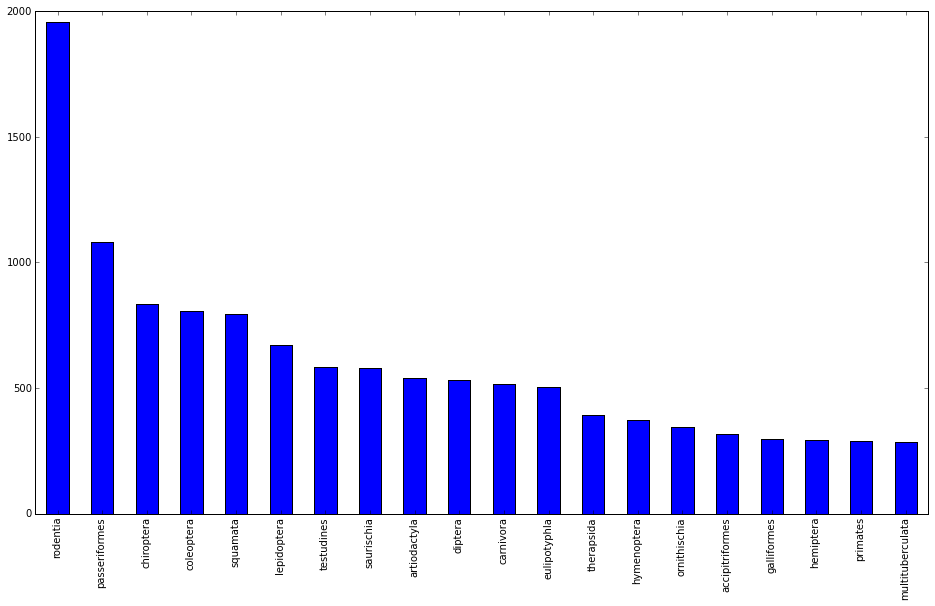

In [10]:
classes = df['order'].value_counts()
print(classes.head(20))
figure(figsize=(16, 9))
classes[0:20].plot(kind="bar")

In [11]:
df[df.duplicated()==True]

,class,family,genus,kingdom,order,page-id,phylum,species,superorder,text,title
20011,insecta,erebidae,callistege,animalia,lepidoptera,2489494,arthropoda,cmi,NaN,"The Mother Shipton Moth, (Callistege mi) is a ...",Callistege mi
20012,NaN,nectocarididae,vetustovermis,animalia,NaN,4173859,mollusca,vplanus,NaN,"Vetustovermis (from Latin: ""very old worm"") is...",Vetustovermis
20013,NaN,dromaeosauridae,achillobatorperlenorellclark1999,animalia,saurischia,3030943,chordata,agiganticus,NaN,Achillobator (/əˌkɪləˈbaɪtɔːr/ a-KILL-ə-BAY-to...,Achillobator
20014,mammalia,cheirogaleidae,allocebuspetterrousseauxandpetter19673,animalia,primates,3124700,chordata,atrichotis,NaN,The hairy-eared dwarf lemur (Allocebus trichot...,Hairy-eared dwarf lemur
20015,aves,alcedinidae,halcyon,animalia,coraciiformes,568834,chordata,hpileata,NaN,The black-capped kingfisher (Halcyon pileata) ...,Black-capped kingfisher
20016,NaN,harpymimidaebarsboldperle1984,harpymimusbarsboldperle1984,animalia,saurischia,3539458,chordata,hokladnikovi,NaN,Harpymimus is a basal ornithomimosaurian thero...,Harpymimus
20017,amphibia,ranidae,lithobates,animalia,anura,2623520,chordata,lpalustris,NaN,"The pickerel frog (Lithobates palustris, forme...",Pickerel frog
20018,actinopterygii,scombridae,scomberomorus,animalia,perciformes,1807941,chordata,smaculatus,NaN,The Atlantic Spanish mackerel (Scomberomorus m...,Atlantic Spanish mackerel
20019,megacheira,yohoiidae,yohoia,animalia,NaN,1114729,arthropoda,ytenuis,NaN,"Yohoia is a genus of tiny, extinct animals fro...",Yohoia
20020,amphibia,plethodontidae,karseniaminetal20052,animalia,urodela,2195312,chordata,kkoreana,NaN,The Korean crevice salamander (Karsenia korean...,Korean crevice salamander


### Create a word count dataframe

In [148]:
count = 0
limit = df.shape[0]
words = {}
word_count_over_time = []
for index, row in df.iterrows():
    if count < limit and row['text'] != '':
        count += 1
        word_count_over_time.append(len(words))
        # remove puncuation and extra spaces, transfrom to lower case and split on spaces
        word_list = re.sub(r'\W+', ' ', str(row['text']).lower()).split(' ')
        for word in word_list:
            if word:
                if word in words:
                    words[word] += 1
                else:
                    words[word] = 1

In [149]:
word_counts = pd.Series(words)
word_counts.sort(ascending=False)
word_counts.head(15)

/Users/jeremy/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from ipykernel import kernelapp as app


the        542740
of         263793
and        262019
in         222099
to         176540
a          168248
is         131599
are         91402
as          70653
species     61744
from        58147
it          57654
with        57498
that        51528
on          48439
dtype: int64

### Just for fun, how does the number of words increase as we count occurences?

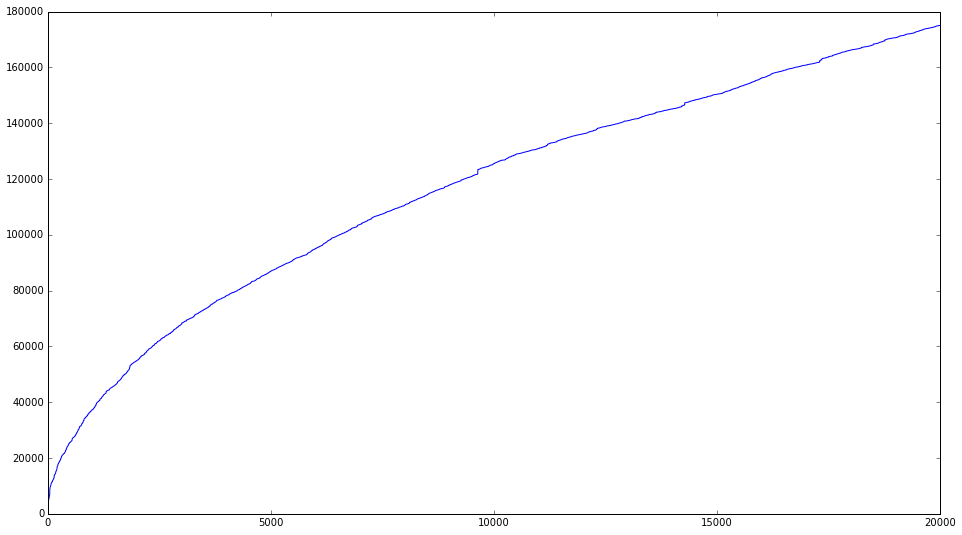

In [150]:
figure(figsize=(16, 9))
plot(word_count_over_time)